## Healpy Info:


The standard coordinates are the colatitude $\theta$, 0 at the North Pole, $\pi / 2$ at the equator and $\pi$ at the South Pole and the longitude $\phi$ between 0 and $2 \pi$ eastward, in a Mollview projection, $\phi = 0$ is at the center and increases toward the left, then wraps around and comes from the right towards the center again.

## All-sky map for discrete simulation.

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0062 (z=0) to 0013 (z=4)
Pre/Sim CPUs 96/128
DM limit for cells: 1000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/CDM_TF50
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/CDM_TF50
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[180.75761547  11.7996673    7.7469711 ]
 [172.04146374  11.73527688   4.96810692]
 [155.63960823  11.60473788  11.06376948]
 [180.75761547  11.7996673    7.7469711 ]
 [299.54209457  12.45775108   8.69090077]
 [299.54209457  12.45775108   8.69090077]
 [233.71493957  12.13443691  11.13076874]
 [172.86606898  11.7415

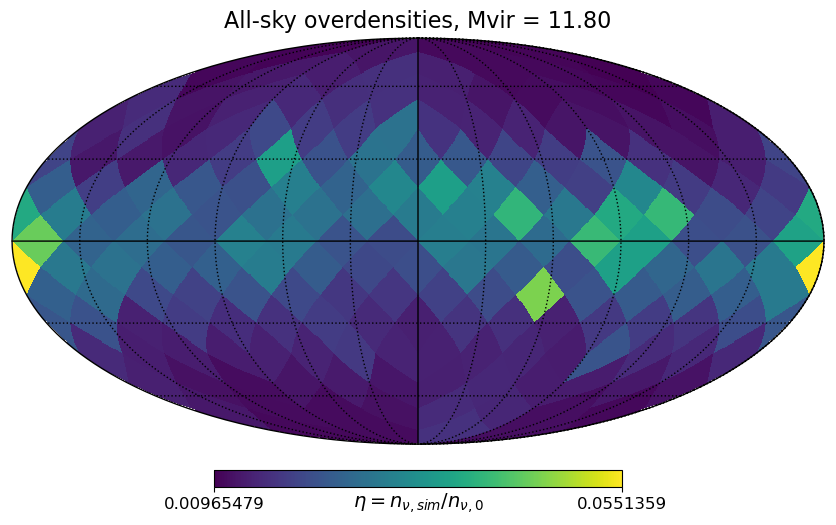

3.7835584206219126


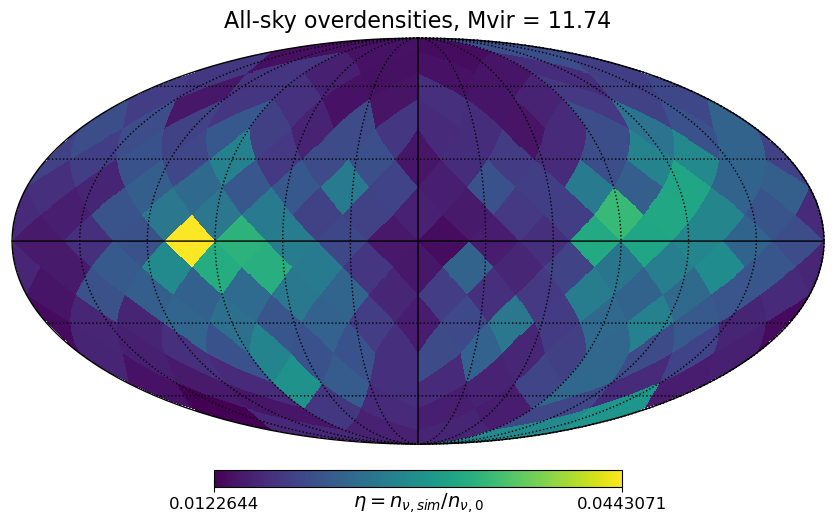

2.8897066925815604


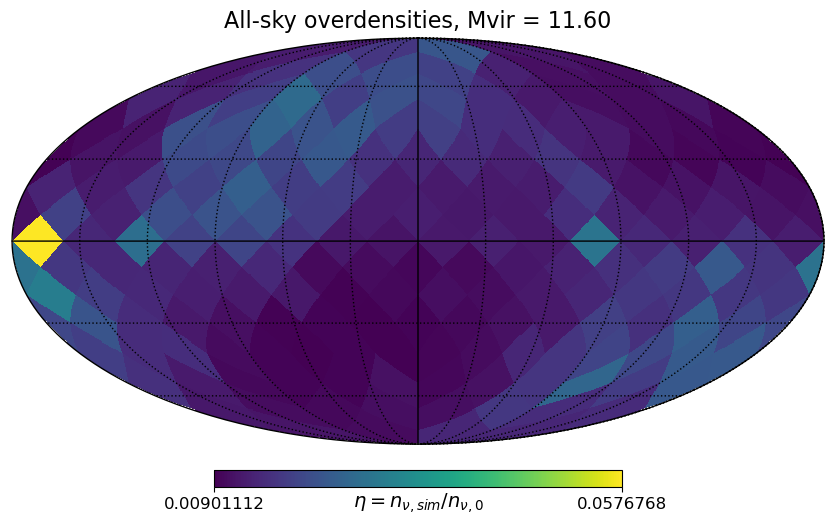

5.458152702242671


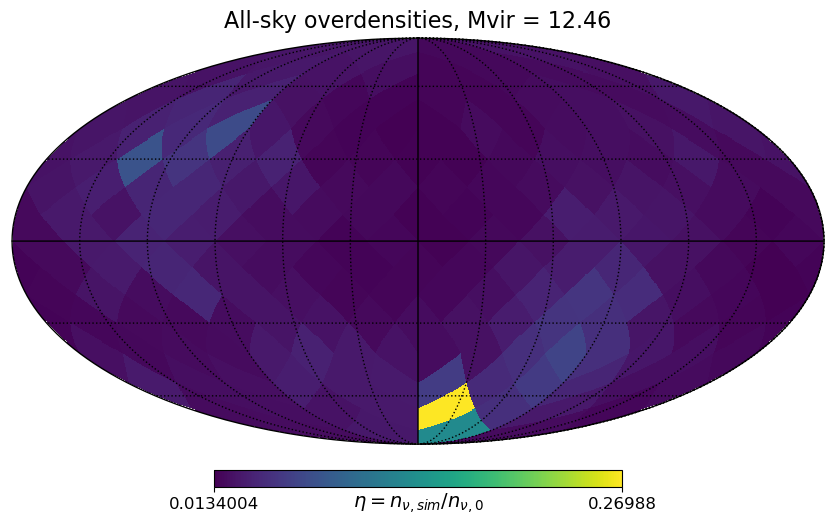

5.018867060804858


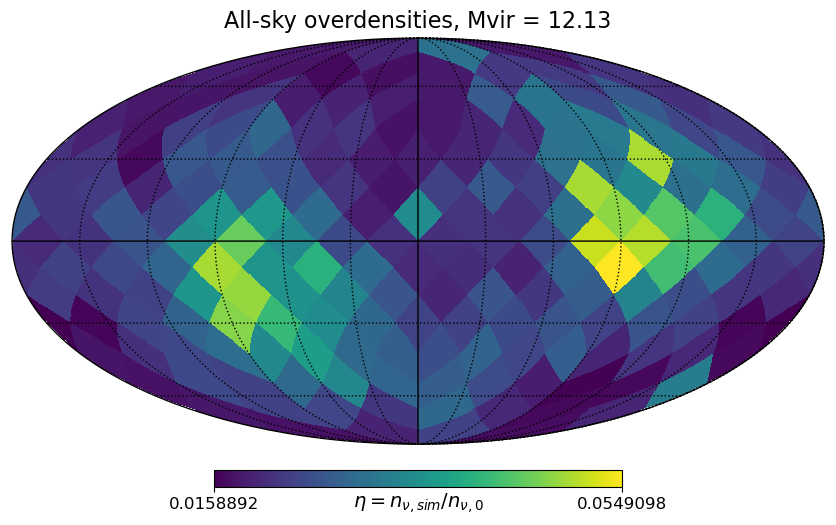

2.6822441970274444


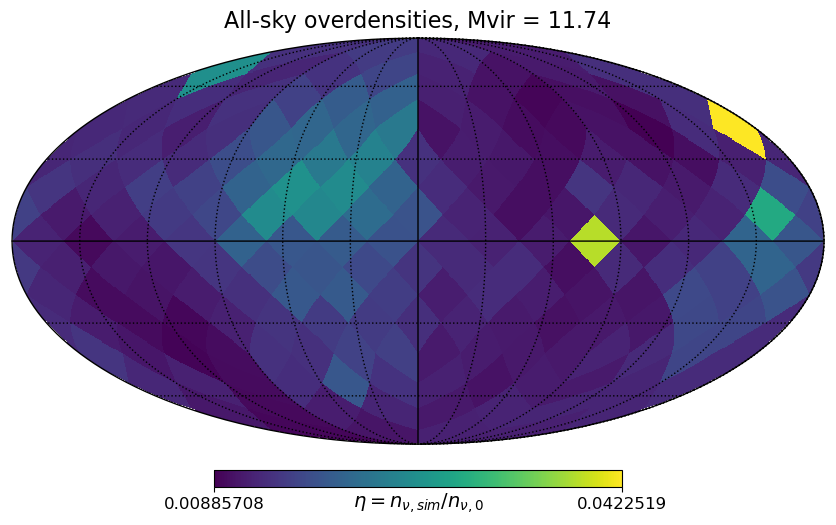

3.1673524607569337


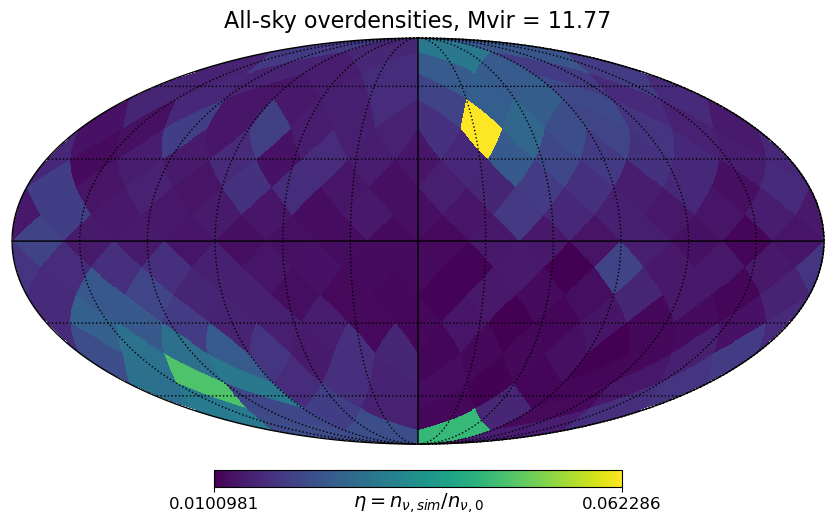

In [11]:
from shared.preface import *
import shared.functions as fct

# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))

# Initialize parameters and files.
PRE = PRE(
    sim='L012N376', 
    z0_snap=62, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=hp_phis, thetas=hp_thetas, vels=10000,
    pre_CPUs=96, sim_CPUs=128
)

mass_gauge = 12.0
mass_range = 0.46
size = 10
hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, PRE.OUT_DIR
)
halo_batch_IDs = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

for halo_j in (0,1,2,4,6,7,8):

    # Load local number densities for all pixels.
    which_mass_eV = 0.3
    mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
    etas_arr = np.zeros(Npix)
    for i in range(Npix):
        CPname = f'{PRE.NUS}nus_{hname}_halo{halo_j}_CoordPair{i+1}'
        out_file = f'{PRE.OUT_DIR}/number_densities_{CPname}.npy'
        etas_arr[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

    print(np.sum(etas_arr))

    hp.mollview(
        etas_arr, 
        title=f'All-sky overdensities, Mvir = {halo_batch_params[halo_j,1]:.2f}', 
        unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$',
        # min=(0.5*np.min(etas_arr)), max=(1.5*np.max(etas_arr))
    )
    hp.graticule()
    plt.show()

## All-sky map for smooth simulation.

### Milky Way halo only.

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW
**********************************************************
4.299203920930351


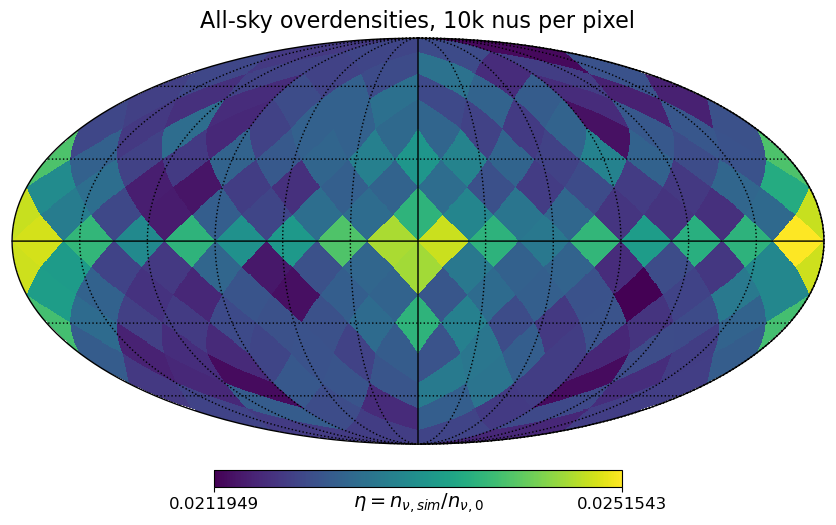

In [12]:
from shared.preface import *
import shared.functions as fct


# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))


# Initialize parameters and files.
PRE = PRE(
    sim='LinfNinf', phis=hp_phis, thetas=hp_thetas, vels=10000,
    sim_CPUs=128, MW_HALO=True
)

# Load local number densities for all pixels.
# note: for <= 0.02eV they come from center, for >= 0.03 they come from sides!
which_mass_eV = 0.3
mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
etas_arr = np.zeros(Npix)
for i in range(Npix):
    CPname = f'{PRE.NUS}nus_smooth_{PRE.HALOS}_{SOLVER}_CoordPair{i+1}'
    out_file = f'{PRE.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

print(np.sum(etas_arr))

hp.mollview(etas_arr, title='All-sky overdensities, 10k nus per pixel', unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$')
hp.graticule()
plt.show()

### Milky Way + Virgo Cluster halos.

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW+VC
**********************************************************
1.0026816080905017


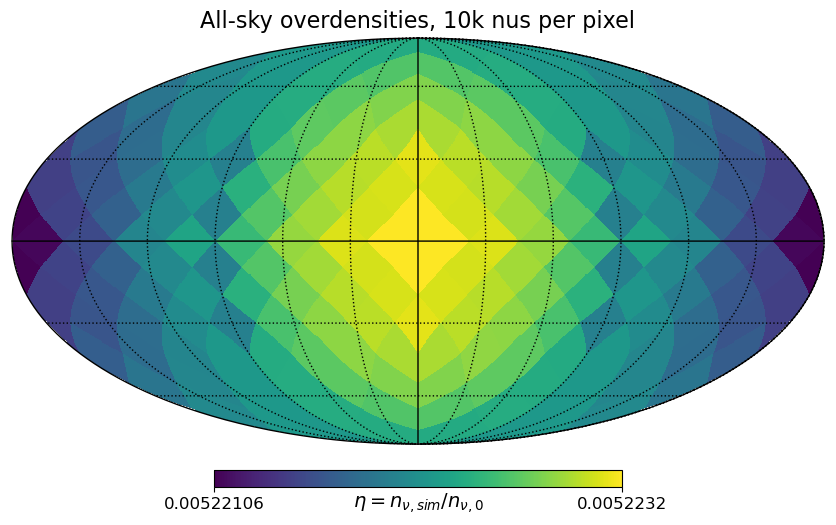

In [13]:
from shared.preface import *
import shared.functions as fct


# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))


# Initialize parameters and files.
PRE = PRE(
    sim='LinfNinf', phis=hp_phis, thetas=hp_thetas, vels=10000,
    sim_CPUs=128, MW_HALO=True, VC_HALO=True
)

# Load local number densities for all pixels.
which_mass_eV = 0.01
mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
etas_arr = np.zeros(Npix)
for i in range(Npix):
    CPname = f'{PRE.NUS}nus_smooth_{PRE.HALOS}_{SOLVER}_CoordPair{i+1}'
    out_file = f'{PRE.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

print(np.sum(etas_arr))


# Check where Virgo Cluster is.
show_VC = False
if show_VC:
    VC_vec = hp.ang2vec(GLON_VC, GLAT_VC, lonlat=True)
    ipix_disc = hp.query_disc(nside=Nside, vec=VC_vec, radius=np.radians(10))
    etas_arr[ipix_disc] = hp.UNSEEN

hp.mollview(etas_arr, title='All-sky overdensities, 10k nus per pixel', unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$')
hp.graticule()
plt.show()